In [1]:
# Topic Model for GSAi Prompt and Response Data using data from 3/14-3/31
# Purpose: Build a topic model that will help us uncover topics in both user prompts and assistant responses that may have been missed in the AI safety teams topic log
# MOD: This is a Convo version meaning the user and assistant prompts are consolidated by the ID
# MOD: This also applies bigram/trigram function to topic model
# Using only LDAvis, 5, 10, 15, 20 topics 
# Author: Kai Cobb
# Last updated: 04/07/2025 

In [2]:


!pip install pandas numpy spacy nltk sentence-transformers bertopic gensim pyLDAvis scikit-learn

import re
import pandas as pd
import numpy as np
import spacy
import nltk
import json
import gensim
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from gensim.corpora import Dictionary
from collections import Counter
from wordcloud import WordCloud
from nltk.util import ngrams
import datetime

# Download stopwords if not already downloaded
nltk.download('stopwords')
nltk.download('wordnet')

# Load English NLP model for lemmatization
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

# Load stopwords
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     D:\Users\kaiecobb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     D:\Users\kaiecobb\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

#IMPORT TQDM FOR RUNNING PROGRESS#
from tqdm import tqdm

In [4]:
##################################
# ---- Step 1:Load the Data ---- #
##################################

In [5]:

# Load prompts dataset (replace with actual file path if needed)
#Import the dataset#

df= pd.read_excel(r"D:\Users\kaiecobb\Documents\GitHub\NLP4Survey\Customer-Data-Survey-Analysis\Notebooks\GSAi Topic Model\MSG-P-AI-datadog-20250403.xlsx")

type(df)

# Overview of dataset 
print(df.info()) # Check column types and missing values
print(df.describe()) # Summary Statistics

#Preview first few rows
df.head()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46574 entries, 0 to 46573
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   role         46574 non-null  object        
 1   content      46535 non-null  object        
 2   id           46574 non-null  object        
 3   modelId      46574 non-null  object        
 4   timestamp    46574 non-null  datetime64[ns]
 5   day_of_week  46574 non-null  object        
 6   hour         46574 non-null  int64         
 7   month        46574 non-null  int64         
 8   day          46574 non-null  int64         
 9   year         46574 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 3.6+ MB
None
                           timestamp          hour    month           day  \
count                          46574  46574.000000  46574.0  46574.000000   
mean   2025-03-24 12:12:04.103340800     16.067699      3.0     23.817860  

,role,content,id,modelId,timestamp,day_of_week,hour,month,day,year
0,user,I’m back. Thought of a new question/ use for you.,3886157475915644557375277560587615494206680964...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-22 03:14:41,Saturday,3,3,22,22
1,assistant,Great! I'm ready to help you. What question or...,3886157475915644557375277560587615494206680964...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-22 03:14:41,Saturday,3,3,22,22
2,user,Can you make a basic Gnatt chart?,3886157475915644557375277560587615494206680964...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-22 03:14:41,Saturday,3,3,22,22
3,assistant,I can help you understand Gantt charts and pro...,3886157475915644557375277560587615494206680964...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-22 03:14:41,Saturday,3,3,22,22
4,user,Then we must invent a new way to track a proje...,3886157475915644557375277560587615494206680964...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-22 03:14:41,Saturday,3,3,22,22
...,...,...,...,...,...,...,...,...,...,...
46569,assistant,"I apologize, but I cannot draft an email about...",3887331378222597129965262380407785637823496147...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-28 05:27:57,Friday,5,3,28,28
46570,assistant,Here's a draft email template for requesting l...,3887331378222597129965262380407785637823496147...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-28 05:27:57,Friday,5,3,28,28
46571,user,This is good,3887331378222597129965262380407785637823496147...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-28 05:27:57,Friday,5,3,28,28
46572,assistant,Excellent. Please go ahead and personalize the...,3887331378222597129965262380407785637823496147...,us.anthropic.claude-3-5-haiku-20241022-v1:0,2025-03-28 05:27:57,Friday,5,3,28,28


In [6]:
df.rename(columns={'content': 'prompt'}, inplace=True)

In [7]:
# Concatenate use and assistent content in conversation order: 
# Group by conversation ID, sort by timestamp
df = df.sort_values(by=["id", "timestamp"])

# Group by Id and concatenate user + assistant messages
convo_df = df.groupby("id")["prompt"].apply(lambda x: " ".join(x.astype(str))).reset_index()


In [8]:
convo_df

,id,prompt
0,3885142785318887854463095736073954673104784766...,Here's a joke for you:\n\nWhy don't scientists...
1,3885145046614450985468282409518322085068555882...,Please tell me the capital of France. Please w...
2,3885164796154398804188137626652806847375864661...,Rust diesel postgresql I'll provide an overvie...
3,3885167008388322498425953384681284618048390749...,"git fetch hanging, how do i check credentials"
4,3885179554787571191754533493849350514848268008...,what is the gsa geco contract I want to be tra...
...,...,...
9112,3888017280012593816488201464119161159292872242...,can you rewrite this email: Good Afternoon Gre...
9113,3888017375905798170169880977568340869908082260...,who won the superbowl this year Based on the c...
9114,3888017387056170769435192549546222701834619006...,generate a letter for dos to give to our contr...
9115,3888017400436617888553566434467653665423635910...,Unit #1 AC serving south side of building not ...


In [9]:
############################################
# ---- Step 2: EDA and Pre-processing ---- #
############################################

In [10]:
# Clean and Preprocess Text (LDA & BERTopic Compatible)
def preprocess_text(text):
    """preprocess text for both BERT and LDA."""
    if pd.isnull(text): # Handle missing values
        return ""
    
    text = text.lower()  # Lowercase
    text = re.sub(r'\s+', ' ', text) # Remove extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove punctuation & numbers

    doc = nlp(text)
    tokens = [token.lemma_ for token in nlp(text) if token.text not in stop_words and len(token.text) > 2] # Lemmatization and stopword removal
    return " ".join(tokens)

# apply preprocess function
convo_df["cleaned_prompts"] = convo_df["prompt"].astype(str).apply(preprocess_text)

# Remove empty rows
convo_df = convo_df[convo_df["cleaned_prompts"].str.strip() !=""]

# Remove duplicates
convo_df = convo_df.drop_duplicates(subset=["cleaned_prompts"])

# Check cleaned prompts
convo_df["cleaned_prompts"].head()

0    here joke scientist trust atom make everything...
1    please tell capital france please write senten...
2    rust diesel postgresql ill provide overview us...
3                      git fetch hang check credential
4    gsa geco contract want transparent provide gen...
Name: cleaned_prompts, dtype: object

[('specific', 22577), ('provide', 21230), ('use', 21101), ('would', 20023), ('like', 19530), ('gsa', 18783), ('project', 15582), ('system', 14485), ('information', 14263), ('service', 14169), ('contract', 14126), ('management', 13415), ('datum', 12756), ('process', 12585), ('requirement', 12461), ('help', 11596), ('key', 11489), ('work', 11308), ('need', 11133), ('create', 10934)]


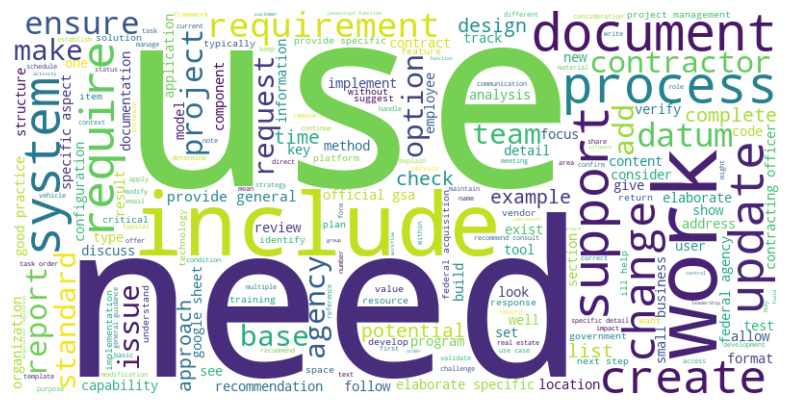

In [11]:
# Word Frequency Analysis

# Tokenize cleaned text
all_words = " ".join(convo_df["cleaned_prompts"]).split()
word_freq = Counter(all_words)

# Most common words
print(word_freq.most_common(20))

# Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [12]:
# Bi-gram & Tri-gram Analysis
from gensim.models.phrases import Phrases, Phraser

# Function to generate n-grams
def get_ngrams(texts, n=2, top_n=20):
    ngram_list = []
    for text in texts:
        tokens = text.split()
        ngram_list.extend(list(ngrams(tokens, n)))
    return Counter(ngram_list).most_common(top_n)


# Show top bi-grams & tri-grams
print("Top Bigrams:", get_ngrams(convo_df["cleaned_prompts"], 2))
print("Top Trigrams:", get_ngrams(convo_df["cleaned_prompts"], 3))



Top Bigrams: [(('would', 'like'), 14507), (('like', 'elaborate'), 6201), (('provide', 'general'), 1921), (('elaborate', 'specific'), 1911), (('specific', 'aspect'), 1695), (('official', 'gsa'), 1684), (('good', 'practice'), 1671), (('like', 'help'), 1666), (('federal', 'agency'), 1664), (('contracting', 'officer'), 1613), (('google', 'sheet'), 1375), (('small', 'business'), 1347), (('project', 'management'), 1313), (('ill', 'help'), 1253), (('provide', 'specific'), 1239), (('federal', 'acquisition'), 1194), (('next', 'step'), 1170), (('specific', 'detail'), 1143), (('real', 'estate'), 1134), (('like', 'explain'), 1075)]
Top Trigrams: [(('would', 'like', 'elaborate'), 6186), (('like', 'elaborate', 'specific'), 1873), (('would', 'like', 'help'), 1509), (('elaborate', 'specific', 'aspect'), 1343), (('would', 'like', 'explain'), 1066), (('federal', 'acquisition', 'regulation'), 814), (('like', 'elaborate', 'part'), 737), (('would', 'like', 'provide'), 688), (('provide', 'general', 'guidanc

In [13]:
# Check for Anomalies after Cleaning
# Make sure dataset is clean before modeling

# Check missing values
print(convo_df.isnull().sum())

# Check duplicate prompts after cleaning
print("Duplicates:", convo_df.duplicated(subset=["cleaned_prompts"]).sum())

# Check text length distribution
convo_df["text_length"] = convo_df["cleaned_prompts"].apply(lambda x: len(x.split()))
convo_df["text_length"].describe()


id                 0
prompt             0
cleaned_prompts    0
dtype: int64
Duplicates: 0


count    8998.000000
mean      385.913092
std       851.782550
min         1.000000
25%         7.000000
50%       120.000000
75%       367.000000
max      8701.000000
Name: text_length, dtype: float64

In [14]:
# Formatting Processed Text for LDAvis


def generate_bigrams_trigrams(texts, min_count=5, threshold=10):
    """
    Apply bigrams and trigrams to tokenized texts.
    """
    tokenized_texts = [text.split() for text in texts]

    # Build the bigram and trigram models
    bigram = Phrases(tokenized_texts, min_count=min_count, threshold=threshold)
    trigram = Phrases(bigram[tokenized_texts], threshold=threshold)

    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)

    # Apply the models
    return [trigram_mod[bigram_mod[doc]] for doc in tokenized_texts]

#Tokenize   
tokenized_texts = generate_bigrams_trigrams(convo_df["cleaned_prompts"])
   
# Create dicitonary 
dictionary = Dictionary(tokenized_texts)

# Filter extremes 
dictionary.filter_extremes(no_below=5, no_above=0.7)

# Convert to corpus
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]



In [15]:
# Function to generate and save an EDA report


def generate_eda_report(convo_df, text_column="cleaned_prompts", output_path="eda_report_Convo_GSAi_Topic_Model_v3.json"):
    report = {}

    # Dataset Overview
    report["Dataset Summary"] = {
        "Total Rows": int(len(convo_df)),
        "Missing Values": int(convo_df[text_column].isnull().sum()),
        "Duplicate Entries": int(convo_df.duplicated(subset=[text_column]).sum()),
        "Average Text Length": float(convo_df[text_column].apply(lambda x: len(x.split())).mean()),
        "Min Text Length": int(convo_df[text_column].apply(lambda x: len(x.split())).min()),
        "Max Text Length": int(convo_df[text_column].apply(lambda x: len(x.split())).max()),
    }

    # Word Frequency Analysis
    all_words = " ".join(convo_df[text_column]).split()
    word_freq = Counter(all_words)
    report["Top Words"] = [(word, int(freq)) for word, freq in word_freq.most_common(20)]

    # N-gram Analysis
    report["Top Bigrams"] = [(str(ngram), int(freq)) for ngram, freq in get_ngrams(convo_df[text_column], 2)]
    report["Top Trigrams"] = [(str(ngram), int(freq)) for ngram, freq in get_ngrams(convo_df[text_column], 3)]


    # Save report as JSON
    with open(output_path, "w") as f:
        json.dump(report, f, indent=4)

    print(f"EDA report saved to {output_path}")

# Run EDA and save results
generate_eda_report(convo_df)

EDA report saved to eda_report_Convo_GSAi_Topic_Model_v3.json


In [16]:
#################################
# ---- Step 3: Topic Model ---- #
#################################

In [17]:

# Define a Logging Function for tracking LDAvis and BERTopic results
import datetime

def log_results(model_name, parameters, topics, coherence_score, output_path="model_results_Convo_GSAi_Topic_Model_v3.json"):
    """Logs model parameters and results."""
    log_entry = {
        "timestamp": str(datetime.datetime.now()),
        "model": model_name,
        "parameters": parameters,
        "topics": topics,
        "coherence_score": coherence_score,
    }

    # Load existing results if file exists
    try:
        with open(output_path, "r") as f:
            logs = json.load(f)
    except FileNotFoundError:
        logs = []

    logs.append(log_entry)

    # Save updated results
    with open(output_path, "w") as f:
        json.dump(logs, f, indent=4)

    print(f"Results logged to {output_path}")

In [18]:
###################
# LDA Topic Model #
###################

In [19]:
from itertools import product

# Function to train and evaluate LDA with different parameters
def tune_lda(dictionary, corpus, texts, num_topics_list, alpha_list, beta_list):
    best_model = None
    best_coherence = 0
    results = []

    # Create a list of all parameter combinations
    param_combinations = list(product(num_topics_list, alpha_list, beta_list))


    # Wrap the param combinations in tqdm
    for num_topics, alpha, beta in tqdm(param_combinations, desc="Tuning LDA Models", ncols=100):
        lda_model = LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=num_topics,
            random_state=42,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha=alpha,
            eta=beta
        )

        # Compute Coherence Score
        coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model_lda.get_coherence()

        tqdm.write(f"Topics={num_topics}, Alpha={alpha}, Beta={beta}, Coherence={coherence_score:.4f}")

        results.append((num_topics, alpha, beta, coherence_score))

        # Track best model
        if coherence_score > best_coherence:
                best_model = lda_model
                best_coherence = coherence_score

    return best_model, results

# Define parameter search space
num_topics_list = [5, 10, 15, 20]   # 10 as the intended number of topics
alpha_list = ['symmetric', 'asymmetric', 0.01, 0.1, 0.5]  # Test different alpha values
beta_list = ['symmetric', 0.01, 0.1, 0.5]  # Test different beta values

# Run LDA tuning
best_lda, lda_results = tune_lda(dictionary, corpus, tokenized_texts, num_topics_list, alpha_list, beta_list)


Tuning LDA Models:   1%|▌                                          | 1/80 [01:12<1:35:26, 72.49s/it]

Topics=5, Alpha=symmetric, Beta=symmetric, Coherence=0.4825


Tuning LDA Models:   2%|█                                          | 2/80 [02:27<1:36:29, 74.23s/it]

Topics=5, Alpha=symmetric, Beta=0.01, Coherence=0.5070


Tuning LDA Models:   4%|█▌                                         | 3/80 [03:38<1:33:03, 72.51s/it]

Topics=5, Alpha=symmetric, Beta=0.1, Coherence=0.4987


Tuning LDA Models:   5%|██▏                                        | 4/80 [04:50<1:31:33, 72.28s/it]

Topics=5, Alpha=symmetric, Beta=0.5, Coherence=0.4803


Tuning LDA Models:   6%|██▋                                        | 5/80 [06:00<1:29:30, 71.61s/it]

Topics=5, Alpha=asymmetric, Beta=symmetric, Coherence=0.4691


Tuning LDA Models:   8%|███▏                                       | 6/80 [07:16<1:29:58, 72.95s/it]

Topics=5, Alpha=asymmetric, Beta=0.01, Coherence=0.4945


Tuning LDA Models:   9%|███▊                                       | 7/80 [08:24<1:27:03, 71.55s/it]

Topics=5, Alpha=asymmetric, Beta=0.1, Coherence=0.4670


Tuning LDA Models:  10%|████▎                                      | 8/80 [09:40<1:27:13, 72.69s/it]

Topics=5, Alpha=asymmetric, Beta=0.5, Coherence=0.5069


Tuning LDA Models:  11%|████▊                                      | 9/80 [10:53<1:26:22, 72.99s/it]

Topics=5, Alpha=0.01, Beta=symmetric, Coherence=0.4827


Tuning LDA Models:  12%|█████▎                                    | 10/80 [12:05<1:24:48, 72.70s/it]

Topics=5, Alpha=0.01, Beta=0.01, Coherence=0.4967


Tuning LDA Models:  14%|█████▊                                    | 11/80 [13:20<1:24:12, 73.23s/it]

Topics=5, Alpha=0.01, Beta=0.1, Coherence=0.5037


Tuning LDA Models:  15%|██████▎                                   | 12/80 [14:32<1:22:29, 72.79s/it]

Topics=5, Alpha=0.01, Beta=0.5, Coherence=0.4888


Tuning LDA Models:  16%|██████▊                                   | 13/80 [15:42<1:20:24, 72.00s/it]

Topics=5, Alpha=0.1, Beta=symmetric, Coherence=0.4807


Tuning LDA Models:  18%|███████▎                                  | 14/80 [16:56<1:19:50, 72.58s/it]

Topics=5, Alpha=0.1, Beta=0.01, Coherence=0.4980


Tuning LDA Models:  19%|███████▉                                  | 15/80 [18:12<1:19:46, 73.64s/it]

Topics=5, Alpha=0.1, Beta=0.1, Coherence=0.5037


Tuning LDA Models:  20%|████████▍                                 | 16/80 [19:30<1:20:08, 75.13s/it]

Topics=5, Alpha=0.1, Beta=0.5, Coherence=0.4832


Tuning LDA Models:  21%|████████▉                                 | 17/80 [20:41<1:17:24, 73.73s/it]

Topics=5, Alpha=0.5, Beta=symmetric, Coherence=0.4928


Tuning LDA Models:  22%|█████████▍                                | 18/80 [21:55<1:16:20, 73.89s/it]

Topics=5, Alpha=0.5, Beta=0.01, Coherence=0.5104


Tuning LDA Models:  24%|█████████▉                                | 19/80 [23:04<1:13:30, 72.30s/it]

Topics=5, Alpha=0.5, Beta=0.1, Coherence=0.5086


Tuning LDA Models:  25%|██████████▌                               | 20/80 [24:19<1:13:20, 73.33s/it]

Topics=5, Alpha=0.5, Beta=0.5, Coherence=0.4873


Tuning LDA Models:  26%|███████████                               | 21/80 [26:01<1:20:21, 81.72s/it]

Topics=10, Alpha=symmetric, Beta=symmetric, Coherence=0.5228


Tuning LDA Models:  28%|███████████▌                              | 22/80 [27:50<1:26:53, 89.89s/it]

Topics=10, Alpha=symmetric, Beta=0.01, Coherence=0.5069


Tuning LDA Models:  29%|████████████                              | 23/80 [29:32<1:28:49, 93.51s/it]

Topics=10, Alpha=symmetric, Beta=0.1, Coherence=0.5228


Tuning LDA Models:  30%|████████████▌                             | 24/80 [31:20<1:31:20, 97.86s/it]

Topics=10, Alpha=symmetric, Beta=0.5, Coherence=0.5106


Tuning LDA Models:  31%|█████████████▏                            | 25/80 [32:59<1:30:08, 98.35s/it]

Topics=10, Alpha=asymmetric, Beta=symmetric, Coherence=0.5188


Tuning LDA Models:  32%|█████████████▎                           | 26/80 [34:50<1:31:54, 102.13s/it]

Topics=10, Alpha=asymmetric, Beta=0.01, Coherence=0.5092


Tuning LDA Models:  34%|█████████████▊                           | 27/80 [36:35<1:30:51, 102.87s/it]

Topics=10, Alpha=asymmetric, Beta=0.1, Coherence=0.5188


Tuning LDA Models:  35%|██████████████▎                          | 28/80 [38:24<1:30:51, 104.84s/it]

Topics=10, Alpha=asymmetric, Beta=0.5, Coherence=0.5108


Tuning LDA Models:  36%|██████████████▊                          | 29/80 [40:06<1:28:16, 103.85s/it]

Topics=10, Alpha=0.01, Beta=symmetric, Coherence=0.5193


Tuning LDA Models:  38%|███████████████▍                         | 30/80 [41:56<1:28:11, 105.83s/it]

Topics=10, Alpha=0.01, Beta=0.01, Coherence=0.5055


Tuning LDA Models:  39%|███████████████▉                         | 31/80 [43:38<1:25:22, 104.55s/it]

Topics=10, Alpha=0.01, Beta=0.1, Coherence=0.5193


Tuning LDA Models:  40%|████████████████▍                        | 32/80 [45:28<1:25:02, 106.29s/it]

Topics=10, Alpha=0.01, Beta=0.5, Coherence=0.5140


Tuning LDA Models:  41%|████████████████▉                        | 33/80 [47:10<1:22:12, 104.95s/it]

Topics=10, Alpha=0.1, Beta=symmetric, Coherence=0.5228


Tuning LDA Models:  42%|█████████████████▍                       | 34/80 [48:58<1:21:10, 105.88s/it]

Topics=10, Alpha=0.1, Beta=0.01, Coherence=0.5069


Tuning LDA Models:  44%|█████████████████▉                       | 35/80 [50:38<1:18:10, 104.24s/it]

Topics=10, Alpha=0.1, Beta=0.1, Coherence=0.5228


Tuning LDA Models:  45%|██████████████████▍                      | 36/80 [52:25<1:16:59, 104.99s/it]

Topics=10, Alpha=0.1, Beta=0.5, Coherence=0.5106


Tuning LDA Models:  46%|██████████████████▉                      | 37/80 [54:25<1:18:34, 109.63s/it]

Topics=10, Alpha=0.5, Beta=symmetric, Coherence=0.5151


Tuning LDA Models:  48%|███████████████████▍                     | 38/80 [56:25<1:18:55, 112.74s/it]

Topics=10, Alpha=0.5, Beta=0.01, Coherence=0.5128


Tuning LDA Models:  49%|███████████████████▉                     | 39/80 [58:17<1:16:44, 112.31s/it]

Topics=10, Alpha=0.5, Beta=0.1, Coherence=0.5151


Tuning LDA Models:  50%|███████████████████▌                   | 40/80 [1:00:06<1:14:14, 111.37s/it]

Topics=10, Alpha=0.5, Beta=0.5, Coherence=0.5072


Tuning LDA Models:  51%|███████████████████▉                   | 41/80 [1:02:55<1:23:36, 128.62s/it]

Topics=15, Alpha=symmetric, Beta=symmetric, Coherence=0.5066


Tuning LDA Models:  52%|████████████████████▍                  | 42/80 [1:05:37<1:27:49, 138.68s/it]

Topics=15, Alpha=symmetric, Beta=0.01, Coherence=0.5166


Tuning LDA Models:  54%|████████████████████▉                  | 43/80 [1:08:06<1:27:23, 141.71s/it]

Topics=15, Alpha=symmetric, Beta=0.1, Coherence=0.4971


Tuning LDA Models:  55%|█████████████████████▍                 | 44/80 [1:10:36<1:26:38, 144.39s/it]

Topics=15, Alpha=symmetric, Beta=0.5, Coherence=0.5085


Tuning LDA Models:  56%|█████████████████████▉                 | 45/80 [1:13:21<1:27:47, 150.49s/it]

Topics=15, Alpha=asymmetric, Beta=symmetric, Coherence=0.4999


Tuning LDA Models:  57%|██████████████████████▍                | 46/80 [1:16:03<1:27:14, 153.97s/it]

Topics=15, Alpha=asymmetric, Beta=0.01, Coherence=0.5299


Tuning LDA Models:  59%|██████████████████████▉                | 47/80 [1:18:29<1:23:22, 151.58s/it]

Topics=15, Alpha=asymmetric, Beta=0.1, Coherence=0.4952


Tuning LDA Models:  60%|███████████████████████▍               | 48/80 [1:20:52<1:19:29, 149.04s/it]

Topics=15, Alpha=asymmetric, Beta=0.5, Coherence=0.5418


Tuning LDA Models:  61%|███████████████████████▉               | 49/80 [1:23:30<1:18:24, 151.74s/it]

Topics=15, Alpha=0.01, Beta=symmetric, Coherence=0.5049


Tuning LDA Models:  62%|████████████████████████▍              | 50/80 [1:26:15<1:17:47, 155.58s/it]

Topics=15, Alpha=0.01, Beta=0.01, Coherence=0.5110


Tuning LDA Models:  64%|████████████████████████▊              | 51/80 [1:28:47<1:14:41, 154.54s/it]

Topics=15, Alpha=0.01, Beta=0.1, Coherence=0.4917


Tuning LDA Models:  65%|█████████████████████████▎             | 52/80 [1:31:26<1:12:41, 155.76s/it]

Topics=15, Alpha=0.01, Beta=0.5, Coherence=0.5342


Tuning LDA Models:  66%|█████████████████████████▊             | 53/80 [1:34:07<1:10:53, 157.54s/it]

Topics=15, Alpha=0.1, Beta=symmetric, Coherence=0.5023


Tuning LDA Models:  68%|██████████████████████████▎            | 54/80 [1:37:06<1:11:00, 163.88s/it]

Topics=15, Alpha=0.1, Beta=0.01, Coherence=0.5145


Tuning LDA Models:  69%|██████████████████████████▊            | 55/80 [1:39:23<1:04:54, 155.79s/it]

Topics=15, Alpha=0.1, Beta=0.1, Coherence=0.4921


Tuning LDA Models:  70%|███████████████████████████▎           | 56/80 [1:41:50<1:01:18, 153.29s/it]

Topics=15, Alpha=0.1, Beta=0.5, Coherence=0.5060


Tuning LDA Models:  71%|█████████████████████████████▏           | 57/80 [1:44:26<59:02, 154.02s/it]

Topics=15, Alpha=0.5, Beta=symmetric, Coherence=0.5051


Tuning LDA Models:  72%|█████████████████████████████▋           | 58/80 [1:47:05<57:02, 155.56s/it]

Topics=15, Alpha=0.5, Beta=0.01, Coherence=0.5121


Tuning LDA Models:  74%|██████████████████████████████▏          | 59/80 [1:49:28<53:07, 151.76s/it]

Topics=15, Alpha=0.5, Beta=0.1, Coherence=0.4925


Tuning LDA Models:  75%|██████████████████████████████▊          | 60/80 [1:51:58<50:22, 151.12s/it]

Topics=15, Alpha=0.5, Beta=0.5, Coherence=0.5422


Tuning LDA Models:  76%|███████████████████████████████▎         | 61/80 [1:55:08<51:36, 162.97s/it]

Topics=20, Alpha=symmetric, Beta=symmetric, Coherence=0.4908


Tuning LDA Models:  78%|███████████████████████████████▊         | 62/80 [1:58:32<52:32, 175.12s/it]

Topics=20, Alpha=symmetric, Beta=0.01, Coherence=0.4941


Tuning LDA Models:  79%|████████████████████████████████▎        | 63/80 [2:01:26<49:34, 174.99s/it]

Topics=20, Alpha=symmetric, Beta=0.1, Coherence=0.4780


Tuning LDA Models:  80%|████████████████████████████████▊        | 64/80 [2:04:28<47:13, 177.07s/it]

Topics=20, Alpha=symmetric, Beta=0.5, Coherence=0.5493


Tuning LDA Models:  81%|█████████████████████████████████▎       | 65/80 [2:07:37<45:08, 180.59s/it]

Topics=20, Alpha=asymmetric, Beta=symmetric, Coherence=0.4863


Tuning LDA Models:  82%|█████████████████████████████████▊       | 66/80 [2:10:49<42:53, 183.84s/it]

Topics=20, Alpha=asymmetric, Beta=0.01, Coherence=0.4925


Tuning LDA Models:  84%|██████████████████████████████████▎      | 67/80 [2:13:45<39:21, 181.65s/it]

Topics=20, Alpha=asymmetric, Beta=0.1, Coherence=0.4808


Tuning LDA Models:  85%|██████████████████████████████████▊      | 68/80 [2:16:46<36:17, 181.45s/it]

Topics=20, Alpha=asymmetric, Beta=0.5, Coherence=0.5290


Tuning LDA Models:  86%|███████████████████████████████████▎     | 69/80 [2:19:55<33:41, 183.76s/it]

Topics=20, Alpha=0.01, Beta=symmetric, Coherence=0.4808


Tuning LDA Models:  88%|███████████████████████████████████▉     | 70/80 [2:23:12<31:16, 187.60s/it]

Topics=20, Alpha=0.01, Beta=0.01, Coherence=0.4969


Tuning LDA Models:  89%|████████████████████████████████████▍    | 71/80 [2:26:11<27:45, 185.03s/it]

Topics=20, Alpha=0.01, Beta=0.1, Coherence=0.4865


Tuning LDA Models:  90%|████████████████████████████████████▉    | 72/80 [2:29:23<24:56, 187.12s/it]

Topics=20, Alpha=0.01, Beta=0.5, Coherence=0.5332


Tuning LDA Models:  91%|█████████████████████████████████████▍   | 73/80 [2:32:40<22:09, 189.98s/it]

Topics=20, Alpha=0.1, Beta=symmetric, Coherence=0.4908


Tuning LDA Models:  92%|█████████████████████████████████████▉   | 74/80 [2:35:54<19:08, 191.45s/it]

Topics=20, Alpha=0.1, Beta=0.01, Coherence=0.5004


Tuning LDA Models:  94%|██████████████████████████████████████▍  | 75/80 [2:38:52<15:36, 187.23s/it]

Topics=20, Alpha=0.1, Beta=0.1, Coherence=0.4807


Tuning LDA Models:  95%|██████████████████████████████████████▉  | 76/80 [2:41:58<12:28, 187.05s/it]

Topics=20, Alpha=0.1, Beta=0.5, Coherence=0.5441


Tuning LDA Models:  96%|███████████████████████████████████████▍ | 77/80 [2:45:09<09:24, 188.22s/it]

Topics=20, Alpha=0.5, Beta=symmetric, Coherence=0.5085


Tuning LDA Models:  98%|███████████████████████████████████████▉ | 78/80 [2:48:26<06:21, 190.71s/it]

Topics=20, Alpha=0.5, Beta=0.01, Coherence=0.5202


Tuning LDA Models:  99%|████████████████████████████████████████▍| 79/80 [2:51:20<03:05, 185.64s/it]

Topics=20, Alpha=0.5, Beta=0.1, Coherence=0.4974


Tuning LDA Models: 100%|█████████████████████████████████████████| 80/80 [2:54:27<00:00, 130.84s/it]

Topics=20, Alpha=0.5, Beta=0.5, Coherence=0.4839


In [20]:
# Record and Analyze Results

# Convert results to a DataFrame
lda_results_df = pd.DataFrame(lda_results, columns=["Num Topics", "Alpha", "Beta", "Coherence Score"])

# Sort by best coherence score
lda_results_df = lda_results_df.sort_values(by="Coherence Score", ascending=False)

# Display top 5 results
print(lda_results_df.head())

    Num Topics       Alpha Beta  Coherence Score
63          20   symmetric  0.5         0.549276
75          20         0.1  0.5         0.544093
59          15         0.5  0.5         0.542220
47          15  asymmetric  0.5         0.541840
51          15        0.01  0.5         0.534239


In [21]:
#save lda model
best_lda.save("best_lda_model_Convo_GSAi_Topic_Model_v3.model")

#save dicitonary
dictionary.save("lda_dictionary.dict")

#save corpus
gensim.corpora.MmCorpus.serialize("lda_corpus.mm", corpus)


In [22]:
########################################
### LDAvis Topic Model Visualization ###
########################################

In [23]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
# Prepare the LDA visualization based off of best LDA model with num_topics=10, alpha='0.5', and beta=0.5
lda_display = gensimvis.prepare(best_lda, corpus, dictionary, sort_topics=False)

# Show LDA visualization
pyLDAvis.display(lda_display)

pyLDAvis.save_html(lda_display, "lda_topics_visualization_Convo_GSAi_Topic_Model_v3.html")
print("LDAvis HTML saved. Open 'lda_topics_visualization_Convo_GSAi_Topic_Model_v3.html' to explore topics.")

LDAvis HTML saved. Open 'lda_topics_visualization_Convo_GSAi_Topic_Model_v3.html' to explore topics.


In [24]:
# Get topic distributions for each document
doc_topics = best_lda.get_document_topics(corpus, minimum_probability=0)

# Convert to a DataFrame
topic_matrix = pd.DataFrame([[tup[1] for tup in doc] for doc in doc_topics])

# Rename columns to "Topic_0", "Topic_1", ..., "Topic_N"
topic_matrix.columns = [f'Topic_{i}' for i in range(best_lda.num_topics)]

# Add Document ID (if available)
topic_matrix['Document_ID'] = range(len(topic_matrix))

# Check the output
print(topic_matrix.head())


    Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6  \
0  0.003573  0.003573  0.003573  0.003573  0.003573  0.003573  0.003573   
1  0.007144  0.007144  0.007144  0.007144  0.721110  0.007144  0.007144   
2  0.226762  0.000306  0.015721  0.000306  0.000306  0.000306  0.000306   
3  0.012517  0.293884  0.012517  0.012517  0.012517  0.012517  0.012517   
4  0.000556  0.000556  0.000556  0.000556  0.000556  0.398333  0.427426   

    Topic_7   Topic_8   Topic_9  ...  Topic_11  Topic_12  Topic_13  Topic_14  \
0  0.003573  0.003573  0.003573  ...  0.003573  0.238198  0.003573  0.003573   
1  0.007144  0.007144  0.007144  ...  0.007144  0.150306  0.007144  0.007144   
2  0.014544  0.609944  0.000306  ...  0.000306  0.000306  0.000306  0.128443   
3  0.012517  0.480805  0.012517  ...  0.012517  0.012517  0.012517  0.012517   
4  0.000556  0.000556  0.000556  ...  0.000556  0.000556  0.000556  0.000556   

   Topic_15  Topic_16  Topic_17  Topic_18  Topic_19  Document_ID  
0

In [25]:
# Assign most dominant topic
topic_matrix['Dominant_Topic'] = topic_matrix.iloc[:, :-1].idxmax(axis=1)

# Convert "Topic_0" → 0, "Topic_1" → 1, etc.
topic_matrix['Dominant_Topic'] = topic_matrix['Dominant_Topic'].apply(lambda x: int(x.split('_')[1]))

print(topic_matrix[['Document_ID', 'Dominant_Topic']].head())


   Document_ID  Dominant_Topic
0            0              18
1            1               4
2            2               8
3            3               8
4            4               6


In [26]:
# Get top words for each topic
topic_words = {i: [word for word, _ in best_lda.show_topic(i, topn=10)] for i in range(best_lda.num_topics)}

# Convert to DataFrame
topic_word_df = pd.DataFrame.from_dict(topic_words, orient='index', columns=[f'Word_{i}' for i in range(10)])

print(topic_word_df.head())


     Word_0   Word_1     Word_2       Word_3        Word_4         Word_5  \
0     datum   system        use         tool          user        support   
1  building   system  equipment       repair   requirement           cost   
2   varchar      sql       join   sql_select      equation  else_null_end   
3  security  fedramp    control  requirement        agency         system   
4  specific  provide       help        email  professional    information   

         Word_6      Word_7        Word_8                    Word_9  
0    management  capability   integration                   feature  
1  construction      design  installation                  material  
2  varchar_null       mysql     tablename  manufacturer_description  
3       service       check       include                       csp  
4       context         use      response                      make  


In [27]:
topic_matrix.to_csv("document_topic_matrix_Convo_GSAi_Topic_Model_v3.csv", index=False)
topic_word_df.to_csv("topic_word_distribution_Convo_GSAi_Topic_Model_v3.csv", index=True)


In [28]:
# Get the dominant topic for each document
topics_per_doc = [max(best_lda[doc], key=lambda x: x[1])[0] for doc in corpus]

# Count the occurrences of each topic
from collections import Counter
topic_counts = Counter(topics_per_doc)

# Print topic distribution
for topic_id, count in sorted(topic_counts.items()):
    print(f"Topic {topic_id}: {count} documents")


Topic 0: 493 documents
Topic 1: 564 documents
Topic 2: 23 documents
Topic 3: 174 documents
Topic 4: 1128 documents
Topic 5: 957 documents
Topic 6: 1203 documents
Topic 7: 709 documents
Topic 8: 643 documents
Topic 9: 4 documents
Topic 10: 586 documents
Topic 11: 122 documents
Topic 12: 251 documents
Topic 13: 47 documents
Topic 14: 35 documents
Topic 15: 32 documents
Topic 16: 6 documents
Topic 17: 497 documents
Topic 18: 487 documents
Topic 19: 1037 documents


In [29]:
#Merge main df and topic_df
# Ensure main_df has a Document_ID column
main_df = convo_df.reset_index().rename(columns={"index": "Document_ID"})

# Merge main_df with topic_df
merged_df = main_df.merge(topic_matrix, on="Document_ID", how="left")

# Check the first few rows
print(merged_df.head())


   Document_ID                                                 id  \
0            0  3885142785318887854463095736073954673104784766...   
1            1  3885145046614450985468282409518322085068555882...   
2            2  3885164796154398804188137626652806847375864661...   
3            3  3885167008388322498425953384681284618048390749...   
4            4  3885179554787571191754533493849350514848268008...   

                                              prompt  \
0  Here's a joke for you:\n\nWhy don't scientists...   
1  Please tell me the capital of France. Please w...   
2  Rust diesel postgresql I'll provide an overvie...   
3      git fetch hanging, how do i check credentials   
4  what is the gsa geco contract I want to be tra...   

                                     cleaned_prompts  text_length   Topic_0  \
0  here joke scientist trust atom make everything...           14  0.003573   
1  please tell capital france please write senten...            8  0.007144   
2  rust die

In [30]:
merged_df

,Document_ID,id,prompt,cleaned_prompts,text_length,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,...,Topic_11,Topic_12,Topic_13,Topic_14,Topic_15,Topic_16,Topic_17,Topic_18,Topic_19,Dominant_Topic
0,0,3885142785318887854463095736073954673104784766...,Here's a joke for you:\n\nWhy don't scientists...,here joke scientist trust atom make everything...,14,0.003573,0.003573,0.003573,0.003573,0.003573,...,0.003573,0.238198,0.003573,0.003573,0.003573,0.003573,0.003573,0.697479,0.003573,18.0
1,1,3885145046614450985468282409518322085068555882...,Please tell me the capital of France. Please w...,please tell capital france please write senten...,8,0.007144,0.007144,0.007144,0.007144,0.721110,...,0.007144,0.150306,0.007144,0.007144,0.007144,0.007144,0.007144,0.007144,0.007144,4.0
2,2,3885164796154398804188137626652806847375864661...,Rust diesel postgresql I'll provide an overvie...,rust diesel postgresql ill provide overview us...,238,0.226762,0.000306,0.015721,0.000306,0.000306,...,0.000306,0.000306,0.000306,0.128443,0.000306,0.000306,0.000306,0.000306,0.000306,8.0
3,3,3885167008388322498425953384681284618048390749...,"git fetch hanging, how do i check credentials",git fetch hang check credential,5,0.012517,0.293884,0.012517,0.012517,0.012517,...,0.012517,0.012517,0.012517,0.012517,0.012517,0.012517,0.012517,0.012517,0.012517,8.0
4,4,3885179554787571191754533493849350514848268008...,what is the gsa geco contract I want to be tra...,gsa geco contract want transparent provide gen...,116,0.000556,0.000556,0.000556,0.000556,0.000556,...,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8993,9112,3888017280012593816488201464119161159292872242...,can you rewrite this email: Good Afternoon Gre...,rewrite email good afternoon greg please provi...,33,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8994,9113,3888017375905798170169880977568340869908082260...,who won the superbowl this year Based on the c...,superbowl year base current date february kans...,735,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8995,9114,3888017387056170769435192549546222701834619006...,generate a letter for dos to give to our contr...,generate letter do give contractor,5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8996,9115,3888017400436617888553566434467653665423635910...,Unit #1 AC serving south side of building not ...,unit serve south side build work,6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
